In [1]:
import pickle
import os
import numpy as np
from scipy.ndimage import label
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import sys
sys.path.append('../') 
from CagePreprocessing import cages, displays, tiles, cells, metadata

In [2]:
chip_id = 159

path_tiles = f'/mnt/data1/users/lminaud/path_chips/Chip{chip_id}/{chip_id}_images/20x/Tiles/'
path_data = f'/mnt/data1/users/lminaud/path_chips/Chip{chip_id}/{chip_id}_data/20x/'
path_bf_tiles = os.path.join(path_tiles, 'BF_illumination_correction')
path_raw_tiles = os.path.join(path_tiles, 'Raw')

# path_predicted_mask = f"/mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/159_masks/predicted_mask_{chip_id}"
# path_predicted_mask = f'/mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/159_masks/predicted_mask_{chip_id}_3_last'
path_predicted_mask = f'/mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/159_masks/predicted_mask_{chip_id}_roi_after_selection'

# pickle file to save the dictionaries at each step of the process
pickle_file_path = os.path.join(os.path.dirname(path_predicted_mask), f'{chip_id}_labels_IS.pkl')
pickle_file_path_filtered = pickle_file_path.split('.')[0] + '_area_filtered.pkl'
pickle_file_path_filtered_global = pickle_file_path.split('.')[0] + '_filtered_global.pkl'
pickle_file_path_filtered_global_ID = pickle_file_path_filtered_global.split('.')[0] + '_cage_ID.pkl'

# path df
path_df_cages = f'/mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/{chip_id}_masks/df_{chip_id}_IS_cages.csv'
path_df_cells = f'/mnt/data1/users/lminaud/path_chips/Chip{chip_id}/{chip_id}_data/20x/filtered_output.tsv' # combined df filtered to avoid redundant cells
path_df_cells_with_cage = f'/mnt/data1/users/lminaud/path_chips/Chip{chip_id}/{chip_id}_data/20x/df_{chip_id}_cell_cage.csv' # add a cage_id column to associate each cell to a cage ID

path_df_all_cages_final = os.path.join(path_data, f"{chip_id}_20X_T0.cages.all.tsv")
path_df_cages_final = os.path.join(path_data, f"{chip_id}_20X_T0.cages.tsv")
path_df_cells_final = os.path.join(path_data, f"{chip_id}_20X_T0.cells.tsv")
path_df_tiles_final = os.path.join(path_data, f"{chip_id}_20X_T0.tiles.tsv")

txt_file_cages_columns = '/mnt/data1/users/lminaud/Resources/Data/cages_load_save_cols.txt'
txt_file_cells_columns = '/mnt/data1/users/lminaud/Resources/Data/cells_load_save_cols.txt'

theoretical_central_cage_id = '11_16'
true_central_cage_id = '11_16' # this is the same cage because all the cages are on the stitch

tile_id_0_0 = '8012' # contain the cage 0_0
tile_id_first = '8012'  # first tile; even without any cage
tile_id_last_row = '8035' # last tile of the row - top left corner

# filter on pixel area
min_px_area, max_px_area = 300, 950 # 860
min_complete_cage, max_complete_cage = 700, 950

## values in PIXEL
x_next_cage_same_row = 985 # distance in px 
y_next_cage_same_column = 985 
x_quincunx = x_next_cage_same_row/2
y_quincunx =  y_next_cage_same_column/2

width, height = cages.get_image_dimensions(path_raw_tiles)
size_tile = width
mpp_tile = metadata.extract_mpp_first_tile(path_raw_tiles)
nb_col = 32  # number of cages in a row (<=> number of columns)
nb_row = 23
y_last_cage_row = 933
x_cage_0_0 = 1010
y_cage_0_0 = 980 # local value of the cage 
bf_id = 3

# global value of cage 0_0 in pixel
x_cage_0_0_global, y_cage_0_0_global = cages.global_cage_coordinates_for_specific_cage(path_tiles = path_raw_tiles, tile_id = tile_id_0_0, x_cage = x_cage_0_0, y_cage = y_cage_0_0, px_output=True, mpp_output=False)
print(f'cage 0_0: ({x_cage_0_0_global}, {y_cage_0_0_global}) px - global coordinates')

cage 0_0: (1010, 980) px - global coordinates


## analyses for Martin

In [4]:
path_df_cages_final = os.path.join(path_data, f"{chip_id}_20X_T0.cages.tsv")
df_cages_final = pd.read_csv(path_df_cages_final, sep = '\t')
df_cages_final

Tile_ID Cage_Status Cage_ID  \
0       8012    complete     0_0   
1       8013    complete     0_1   
2       8014    complete     0_2   
3       8014    complete     0_3   
4       8015    complete     0_4   
..       ...         ...     ...   
730     8489    complete   22_28   
731     8490    complete   22_29   
732     8490    complete   22_30   
733     8491    complete   21_31   
734     8491    complete   22_31   

                                        geometry_cages  Cell_Count_Cage  \
0    LINESTRING (1116 1141, 1116 1139, 1116 1137, 1...                1   
1    LINESTRING (1589 785, 1589 783, 1589 781, 1589...                4   
2    LINESTRING (1078 482, 1078 480, 1078 478, 1078...                1   
3    LINESTRING (1633 1440, 1633 1439, 1633 1437, 1...                0   
4    LINESTRING (1118 1141, 1118 1139, 1118 1137, 1...                0   
..                                                 ...              ...   
730  LINESTRING (901 794, 901 792, 901 790, 901 789...                3   
731  LINESTRING (1371 424, 1371 422, 1370 421, 1369...                2   
732  LINESTRING (937 1442, 937 1440, 937 1439, 937 ...                2   
733  LINESTRING (430 1159, 430 1157, 429 1156, 428 ...                0   
734  LINESTRING (1409 1097, 1409 1095, 1409 1094, 1...                1   

    Tile_Row_Col  Ref_TileID  X_Cage_Center_Local  Y_Cage_Center_Local  \
0         (0, 0)        8012                 1009                  967   
1         (0, 1)        8013                  656                 1442   
2         (0, 2)        8014                  357                  928   
3         (0, 2)        8014                 1311                 1481   
4         (0, 3)        8015                 1014                  969   
..           ...         ...                  ...                  ...   
730     (19, 21)        8489                  666                  753   
731     (19, 22)        8490                  302                 1226   
732     (19, 22)        8490                 1313                  790   
733     (19, 23)        8491                 1029                  279   
734     (19, 23)        8491                  970                 1263   

     X_Cage_Center_Global  ...  H_UMIs_cage  M_UMIs_cage  UGC_cage  MT_cage  \
0                    1009  ...          NaN          NaN       NaN      NaN   
1                    1966  ...          NaN          NaN       NaN      NaN   
2                    2978  ...          NaN          NaN       NaN      NaN   
3                    3932  ...          NaN          NaN       NaN      NaN   
4                    4946  ...          NaN          NaN       NaN      NaN   
..                    ...  ...          ...          ...       ...      ...   
730                 27718  ...          NaN          NaN       NaN      NaN   
731                 28665  ...          NaN          NaN       NaN      NaN   
732                 29676  ...          NaN          NaN       NaN      NaN   
733                 30703  ...          NaN          NaN       NaN      NaN   
734                 30644  ...          NaN          NaN       NaN      NaN   

     RP_cage  UMAP1_sc  UMAP2_sc  PCA1_sc  PCA2_sc  Leiden_sc  
0        NaN       NaN       NaN      NaN      NaN        NaN  
1        NaN       NaN       NaN      NaN      NaN        NaN  
2        NaN       NaN       NaN      NaN      NaN        NaN  
3        NaN       NaN       NaN      NaN      NaN        NaN  
4        NaN       NaN       NaN      NaN      NaN        NaN  
..       ...       ...       ...      ...      ...        ...  
730      NaN       NaN       NaN      NaN      NaN        NaN  
731      NaN       NaN       NaN      NaN      NaN        NaN  
732      NaN       NaN       NaN      NaN      NaN        NaN  
733      NaN       NaN       NaN      NaN      NaN        NaN  
734      NaN       NaN       NaN      NaN      NaN        NaN  

[735 rows x 47 columns]

In [7]:
count_equals_1_ids = df_cages_final[df_cages_final['Cell_Count_Cage'] == 1]['Cage_ID'].tolist()
print("Cage_IDs with Cell_Count_Cage equal to 1:")
print(len(count_equals_1_ids))


Cage_IDs with Cell_Count_Cage equal to 1:
235


In [8]:
# chip_id = 178

# path_tiles = f'/mnt/data1/users/lminaud/path_chips/Chip{chip_id}/{chip_id}_images/20x/Tiles/'
# path_bf_tiles = os.path.join(path_tiles, 'BF-T0')
# path_raw_tiles = os.path.join(path_tiles, 'Raw')

# path_predicted_mask = f"/mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/177_178_180_masks/predicted_mask_{chip_id}"

# # pickle file to save the dictionaries at each step of the process
# pickle_file_path = os.path.join(os.path.dirname(path_predicted_mask), f'{chip_id}_labels_IS.pkl')
# pickle_file_path_filtered = pickle_file_path.split('.')[0] + '_area_filtered.pkl'
# pickle_file_path_filtered_global = pickle_file_path.split('.')[0] + '_filtered_global.pkl'
# pickle_file_path_filtered_global_ID = pickle_file_path_filtered_global.split('.')[0] + '_cage_ID.pkl' # 70 MB for Chip 178 final dictionary

# # path df
# path_df_cages = '/mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/177_178_180_masks/df_178_IS_cages.csv'
# path_df_cages_cell_count = '/mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/177_178_180_masks/df_178_IS_cages_with_cell_counts.csv'
# path_df_cells = '/mnt/data1/users/lminaud/path_chips/Chip178/178_data/20x/26_Sep_2024___14h_25m_37s_178_20X.cells.tsv'
# path_df_cells_with_cage = '/mnt/data1/users/lminaud/path_chips/Chip178/178_data/20x/df_cell_cage.csv' # add a cage_id column to associate each cell to a cage ID

# theoretical_central_cage_id = '21_50' # tile 0734 - visualized on the stitch
# true_central_cage_id = '21_50' 

# tile_id_0_0 = '0043' # contain the cage 0_0
# tile_id_first = '0001'  # first tile; even without any cage
# tile_id_last_row = '0041' # last tile of the row - top left corner

# # filter on pixel area
# min_px_area, max_px_area = 270, 1350
# min_complete_cage, max_complete_cage = 1230, 1350

# ## values in PIXEL
# mpp_tile = 0.325
# size_tile = 2304
# x_next_cage_same_row = 680 # distance in px 
# y_next_cage_same_column = 1470 # distance in px 
# nb_col = 115
# nb_row = 41
# y_last_cage_row = 1656
# x_cage_0_0 = 270
# y_cage_0_0 = 2150 # local value of the cage if the tile 0001 contains the cage 0_0. Otherwise, calculate the cage global value 

# # global value of cage 0_0
# x_cage_0_0_global, y_cage_0_0_global = cages.global_cage_coordinates_for_specific_cage(path_tiles = path_raw_tiles, tile_id = tile_id_0_0, x_cage = x_cage_0_0, y_cage = y_cage_0_0, px_output=True, mpp_output=False)
# print(f'cage 0_0: ({x_cage_0_0_global}, {y_cage_0_0_global}) px - global coordinates')

## Create dictionary with coordinates for each label

In [4]:
dict_labels_coordinates = cages.process_predicted_masks(path_predicted_mask, path_bf_tiles, tile_size=size_tile, base_size=1152, 
                                                        show=False, lim=None)

In [5]:
# Save the dictionary to a pickle file
with open(pickle_file_path, 'wb') as file:
    pickle.dump(dict_labels_coordinates, file)

print(f"Dictionary saved to {pickle_file_path}")

Dictionary saved to /mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/159_masks/159_labels_IS.pkl


## Cages' area
- Filter on pixel area
- Add to the dictionary if the cage is complete in the tile based on its area

In [23]:
# Load dictionary 
with open(pickle_file_path, 'rb') as file:
    dict_labels_coordinates = pickle.load(file)
print(len(dict_labels_coordinates))

480


In [24]:
dict_area = cages.add_area_to_dict(dict_labels_coordinates)

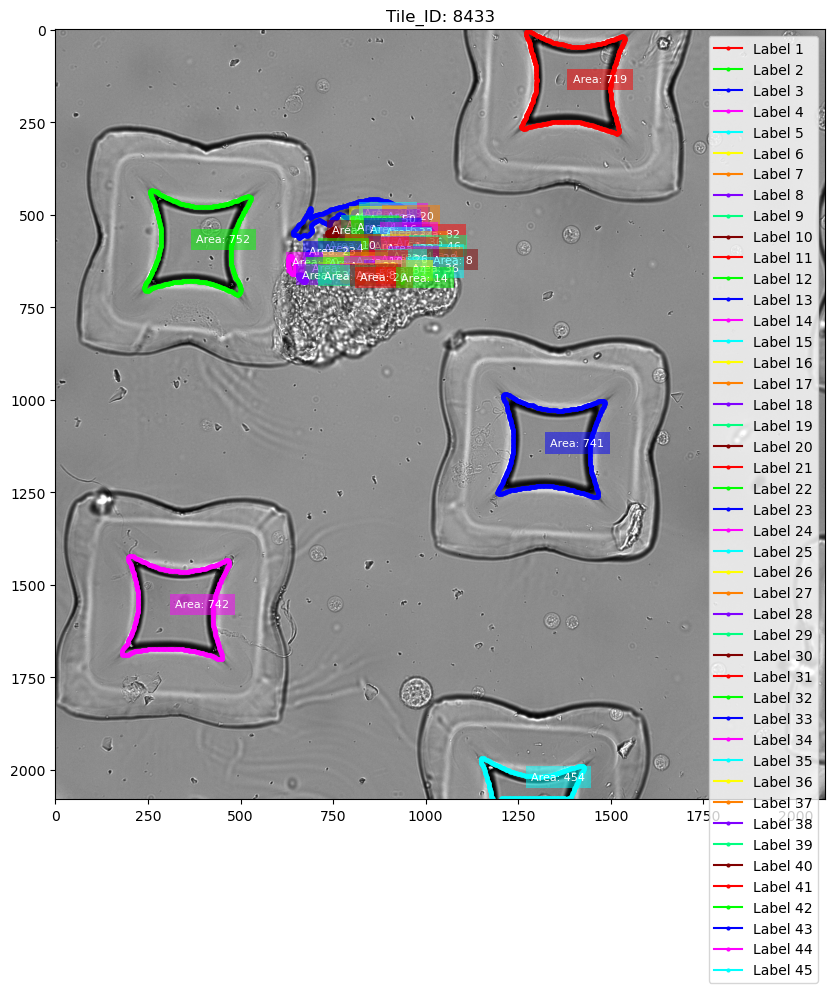

In [25]:
tile_id = '8433'
displays.display_tile_with_borders_and_area(path_bf_tiles=path_bf_tiles, tile_id = tile_id, result_dict=dict_area, 
                                            show_area=True, suffix = '')

## Filter on pixel area

In [9]:
filtered_result_dict = cages.filter_dictionary_by_area(dict_area, filter_area_range=[min_px_area, max_px_area], complete_cage_range=[min_complete_cage, max_complete_cage])
print(len(filtered_result_dict))

480


In [10]:
# Save the dictionary to a pickle file
with open(pickle_file_path_filtered, 'wb') as file:
    pickle.dump(filtered_result_dict, file)

print(f"Dictionary saved to {pickle_file_path_filtered}")

Dictionary saved to /mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/159_masks/159_labels_IS_area_filtered.pkl


## Add global center coordinates

In [11]:
# Load dictionary 
with open(pickle_file_path_filtered, 'rb') as file:
    filtered_result_dict = pickle.load(file)
print(len(filtered_result_dict))

480


In [12]:
dict_global_coord_cages = cages.dict_global_cage_coordinates(path_raw_tiles=path_raw_tiles, result_dict=filtered_result_dict, suffix='')

In [13]:
print(dict_global_coord_cages[tile_id_0_0][1].keys())

dict_keys(['list_coordinates', 'center_local', 'area', 'complete', 'center_global'])


In [14]:
# Save the dictionary to a pickle file
with open(pickle_file_path_filtered_global, 'wb') as file:
    pickle.dump(dict_global_coord_cages, file)

print(f"Dictionary saved to {pickle_file_path_filtered_global}")

Dictionary saved to /mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/159_masks/159_labels_IS_filtered_global.pkl


## Identify cages

In [15]:
# Load dictionary 
with open(pickle_file_path_filtered_global, 'rb') as file:
    dict_global_coord_cages = pickle.load(file)
print(len(dict_global_coord_cages))

480


In [16]:
theta_degrees = cages.calculate_theta_angle(
    path_raw_tiles = path_raw_tiles, 
    tile_id_first_cage = tile_id_0_0, # contain the cage 0_0
    tile_id_ref = tile_id_first, # first tile; even without any cage
    tile_id_last = tile_id_last_row, # last tile of the row
    suffix = None,
    dist_btw_cages_px = x_next_cage_same_row, # distance between two center cages in pixels
    nb_col = nb_col, # number of cages in a row (<=> number of columns)
    y_first_cage = y_cage_0_0_global, # y value of cage 0_0 in pixel 
    y_last_cage_row = y_last_cage_row, # y value of the last cage in pixel 
)

Theta (degrees) = 2.1


In [17]:
## line
# dict_theoretical_cage_id = cages.dict_id_cage_theoretical_coord_angle_cages_in_line(nb_row=nb_row, nb_col=nb_col, x_next_cage_same_row=x_next_cage_same_row*mpp_tile, y_next_cage_same_column=y_next_cage_same_column*mpp_tile, theta=theta_degrees, x_cage_0_0=x_cage_0_0*mpp_tile, y_cage_0_0=y_cage_0_0_global*mpp_tile, mpp_20x=mpp_tile)

## quincunx 
dict_theoretical_cage_id = cages.dict_id_cage_theoretical_coord_angle(nb_cage_row=nb_row, nb_cage_col=nb_col, x_next_cage_same_row=x_next_cage_same_row*mpp_tile, y_next_cage_same_column=y_next_cage_same_column*mpp_tile, theta=theta_degrees, x_cage_0_0=x_cage_0_0*mpp_tile, y_cage_0_0=y_cage_0_0_global*mpp_tile, x_quincunx=x_quincunx*mpp_tile, y_quincunx=y_quincunx*mpp_tile, mpp=mpp_tile)

In [18]:
tile_id = '8071'
print(dict_global_coord_cages[tile_id][2]['center_global']) 

(14722, 3468)


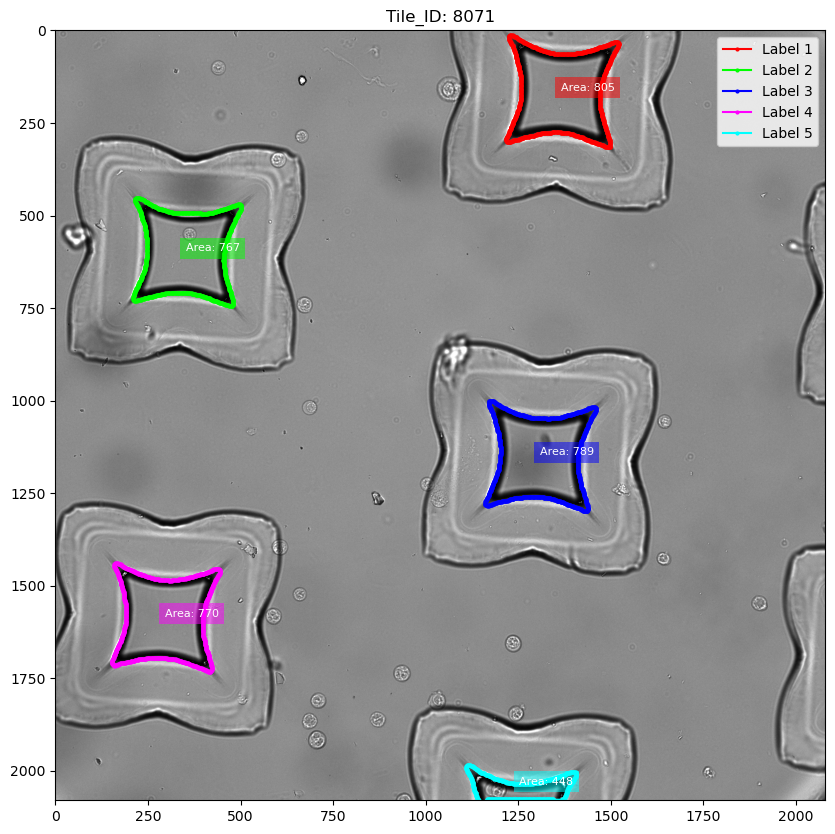

In [19]:
displays.display_tile_with_borders_and_area(path_bf_tiles=path_bf_tiles, tile_id = tile_id, result_dict=dict_global_coord_cages, 
                                            show_area=True, suffix = '')

In [20]:
dict_id = cages.associate_cage_id_to_coord_dict(dict_global_coord_cages, dict_theoretical_cage_id) # match

In [21]:
# Save the dictionary to a pickle file
with open(pickle_file_path_filtered_global_ID, 'wb') as file:
    pickle.dump(dict_id, file)

print(f"Dictionary saved to {pickle_file_path_filtered_global_ID}")

Dictionary saved to /mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/159_masks/159_labels_IS_filtered_global_cage_ID.pkl


## Display cage ID

In [4]:
# Load dictionary 
with open(pickle_file_path_filtered_global_ID, 'rb') as file:
    dict_id = pickle.load(file)
print(len(dict_id))

480


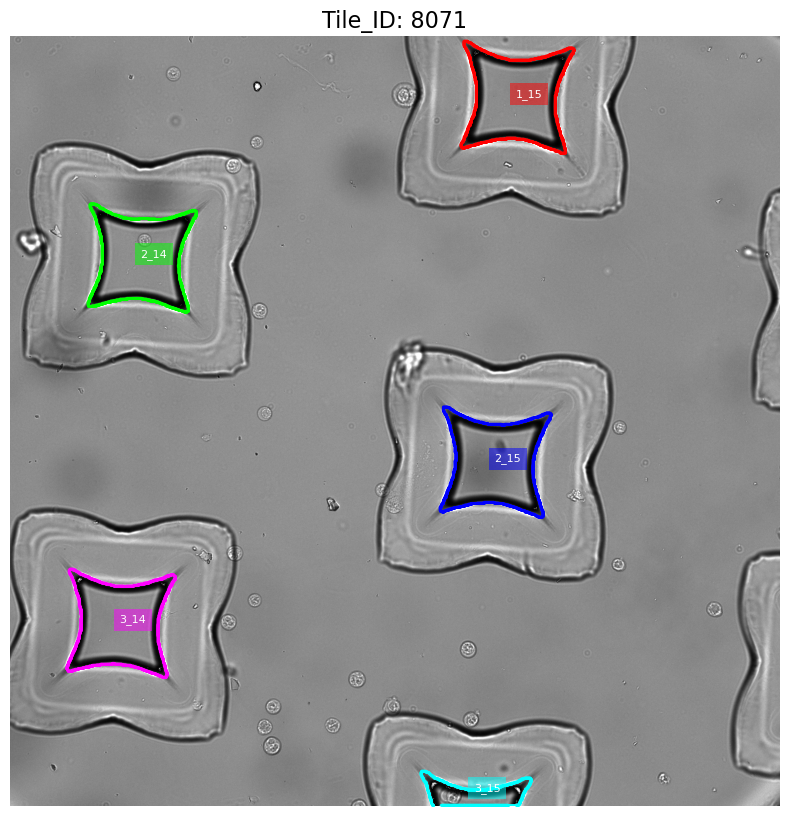

In [5]:
displays.display_cages_with_consistent_colors(path_bf_tiles=path_bf_tiles, tile_id='8071', result_dict=dict_id, display_ids=True, suffix = '')

## Change cage ID based on the central cage

In [6]:
## I want to check if this is working with a chip we know the true central cage ID before uploading it on Github.

def reassign_cageID_from_dict(
    dict_id: dict,
    theoretical_central_cage_id: str,
    true_central_cage_id: str
) -> dict:
    """
    Reassigns the 'cage_id' in a nested dictionary based on the true central cage ID.

    Args:
        dict_id (dict): Dictionary containing tiles with their associated information.
        theoretical_central_cage_id (str): Theoretical cage ID of the central cage.
        true_central_cage_id (str): True cage ID of the central cage.

    Returns:
        dict: Updated dictionary with new cage_id values.
    """

    # Extract row and column from the theoretical and true central cage IDs
    theoretical_row_central_cage_id, theoretical_col_central_cage_id = map(
        int, theoretical_central_cage_id.split("_")
    )
    true_row_central_cage_id, true_col_central_cage_id = map(
        int, true_central_cage_id.split("_")
    )

    # Calculate the shift between the true central cage and the theoretical central cage
    row_shift = true_row_central_cage_id - theoretical_row_central_cage_id
    col_shift = true_col_central_cage_id - theoretical_col_central_cage_id

    # Iterate through the dictionary and update each 'cage_id'
    for tile_id, tile_data in dict_id.items():
        for label, data in tile_data.items():
            # Split the 'cage_id' and calculate the new values
            cage_row, cage_col = map(int, data['cage_id'].split("_"))
            new_cage_row = cage_row + row_shift
            new_cage_col = cage_col + col_shift

            # Update the 'cage_id' in the dictionary
            data['cage_id'] = f"{new_cage_row}_{new_cage_col}"

    return dict_id


In [7]:
updated_dict = reassign_cageID_from_dict(dict_id, theoretical_central_cage_id, true_central_cage_id)


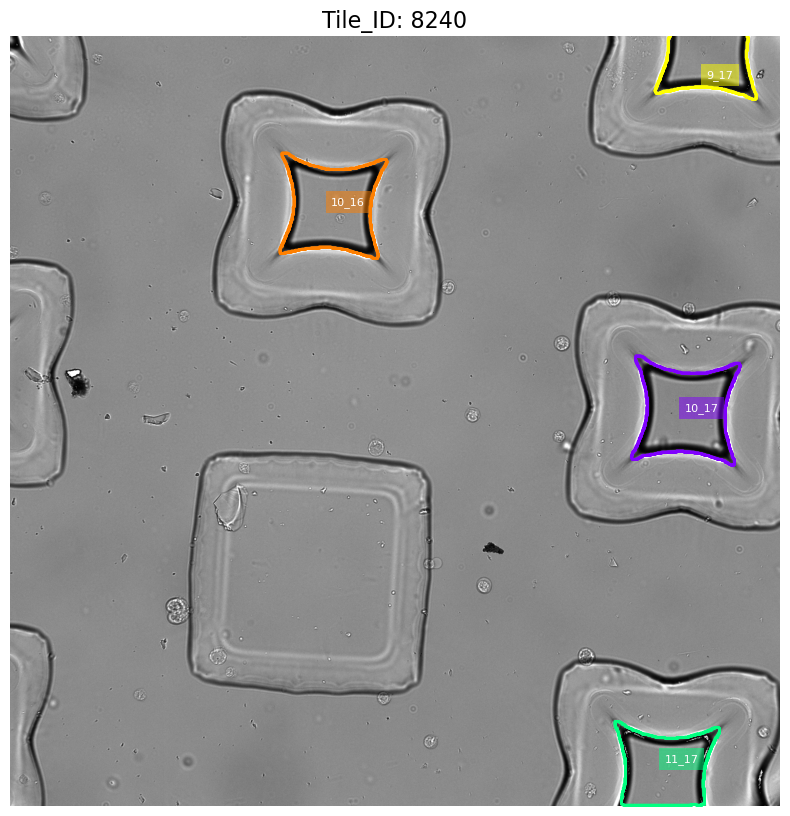

In [8]:
displays.display_cages_with_consistent_colors(path_bf_tiles=path_bf_tiles, tile_id='8240', result_dict=updated_dict, display_ids=True, suffix = '')

## Add cell count for each cage to the dictionary

In [27]:
# Load dictionary 
with open(pickle_file_path_filtered_global_ID, 'rb') as file:
    dict_id = pickle.load(file)
print(len(dict_id))

480


In [28]:
## Swap the two columns of X and Y of the df_cells - do it 1 time !

# df_cells = pd.read_csv(path_df_cells, sep='\t', dtype={'TileID': str})

# # Step 1: Rename 'CellCenterX' to a temporary column 'TempCol' to avoid losing its data
# df_cells = df_cells.rename(columns={'CellCenterX': 'TempCol'})

# # Step 2: Rename 'CellCenterY' to 'CellCenterX'
# df_cells = df_cells.rename(columns={'CellCenterY': 'CellCenterX'})

# # Step 3: Rename 'TempCol' (which holds the original 'CellCenterX') to 'CellCenterY'
# df_cells = df_cells.rename(columns={'TempCol': 'CellCenterY'})

# df_cells.to_csv(path_df_cells, sep='\t', index=False)

In [29]:
dict_id = cages.count_cells_in_cages(dict_id, path_df_cells)

In [30]:
tile_id = '8016'
label = 1
dict_id[tile_id][label].keys()

dict_keys(['list_coordinates', 'center_local', 'area', 'complete', 'center_global', 'cage_id', 'Cell_Count_Cage'])

In [31]:
tile_id = '8016'
label = 1
dict_id[tile_id][label]['cage_id']
dict_id[tile_id][label]['Cell_Count_Cage']

4

In [32]:
# Display single cell cages

# Iterate through each TileID in the dictionary
for tile_id, tile_data in dict_id.items():
    # Iterate through each cage (label) in the tile
    for label, cage_data in tile_data.items():
        # Check if 'Cell_Count_Cage' exists and equals 1
        if cage_data.get('Cell_Count_Cage') == 1:
            if cage_data.get('complete') == True:
                # Assuming 'cage_id' is part of the cage_data
                cage_id = cage_data.get('cage_id', 'Unknown Cage ID')  # Default value if 'cage_id' is missing
                print(f"TileID: {tile_id}, Cage ID: {cage_id}")

TileID: 8012, Cage ID: 0_0
TileID: 8014, Cage ID: 0_2
TileID: 8014, Cage ID: 1_2
TileID: 8021, Cage ID: 0_12
TileID: 8023, Cage ID: 0_15
TileID: 8025, Cage ID: 0_18
TileID: 8026, Cage ID: 0_18
TileID: 8026, Cage ID: 0_19
TileID: 8029, Cage ID: 1_22
TileID: 8030, Cage ID: 0_24
TileID: 8031, Cage ID: 0_26
TileID: 8032, Cage ID: 0_26
TileID: 8034, Cage ID: 0_30
TileID: 8035, Cage ID: 0_30
TileID: 8036, Cage ID: 2_0
TileID: 8037, Cage ID: 1_2
TileID: 8038, Cage ID: 1_2
TileID: 8040, Cage ID: 1_5
TileID: 8041, Cage ID: 0_7
TileID: 8041, Cage ID: 1_6
TileID: 8043, Cage ID: 2_10
TileID: 8044, Cage ID: 2_10
TileID: 8046, Cage ID: 1_13
TileID: 8046, Cage ID: 2_14
TileID: 8047, Cage ID: 0_15
TileID: 8048, Cage ID: 1_16
TileID: 8049, Cage ID: 2_18
TileID: 8050, Cage ID: 0_19
TileID: 8050, Cage ID: 2_18
TileID: 8052, Cage ID: 1_22
TileID: 8053, Cage ID: 1_22
TileID: 8058, Cage ID: 0_29
TileID: 8060, Cage ID: 2_0
TileID: 8060, Cage ID: 2_1
TileID: 8061, Cage ID: 2_1
TileID: 8062, Cage ID: 2_3
TileI

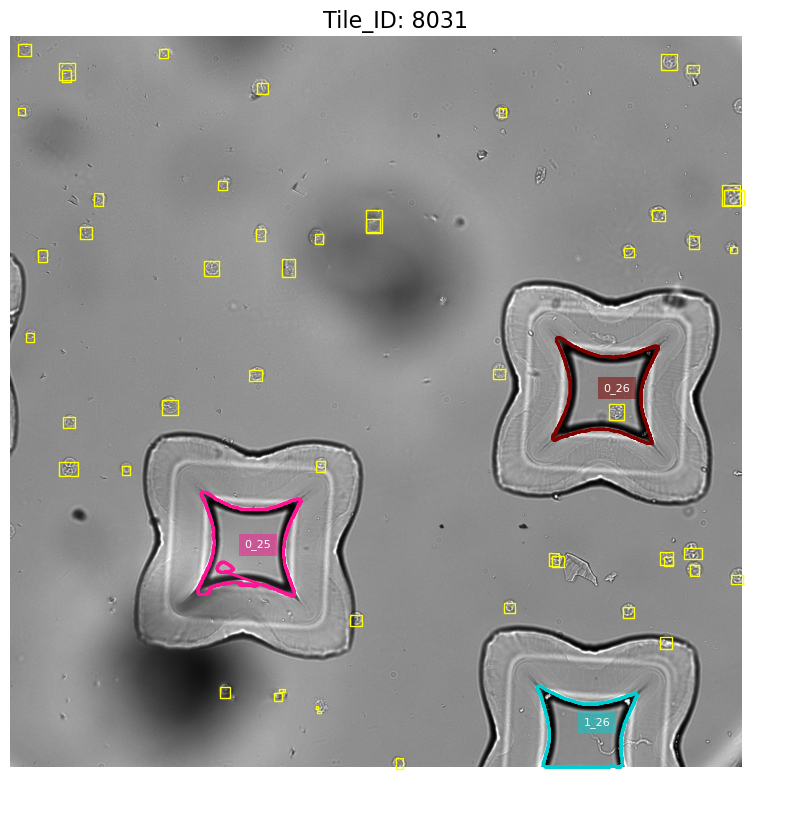

In [33]:
displays.display_cages_with_consistent_colors_with_cells(path_bf_tiles=path_bf_tiles, tile_id='8031', result_dict=dict_id, path_df_cells = path_df_cells, display_ids=True, suffix = '')

In [34]:
# Save the dictionary to a pickle file
with open(pickle_file_path_filtered_global_ID, 'wb') as file:
    pickle.dump(dict_id, file)

print(f"Dictionary saved to {pickle_file_path_filtered_global_ID}")

Dictionary saved to /mnt/data1/users/lminaud/Minos_Image_Analysis/Kartezio_Minos/159_masks/159_labels_IS_filtered_global_cage_ID.pkl


## Associate each cell to a cage ID or Nan value to df_cells

In [35]:
# this does not modify the dictionary - only the df_cells 

In [36]:
# Load dictionary 
with open(pickle_file_path_filtered_global_ID, 'rb') as file:
    dict_id = pickle.load(file)

In [37]:
df_cells_cageID_col = cells.assign_cells_to_cages(dict_id, path_df_cells)

In [38]:
# save df
df_cells_cageID_col.to_csv(path_df_cells_with_cage, index=False)

## Create a df from the dictionary 

In [39]:
# Load dictionary 
with open(pickle_file_path_filtered_global_ID, 'rb') as file:
    dict_id = pickle.load(file)

In [40]:
tile_id = '8012'
label = 1

dict_id[tile_id][label].keys()

dict_keys(['list_coordinates', 'center_local', 'area', 'complete', 'center_global', 'cage_id', 'Cell_Count_Cage'])

In [41]:
df_geo = cages.create_geodf_from_dict(dict_id)
df_geo


TileID  center_local  area cage_status   center_global cage_id  \
0      8012   (1009, 967)   818    complete     (1009, 967)     0_0   
1      8012  (1927, 1520)   619         NaN    (1927, 1520)     0_1   
2      8012   (950, 1935)   701    complete     (950, 1935)     1_0   
3      8013  (1669, 1007)   822    complete    (2979, 1058)     0_2   
4      8013   (656, 1442)   794    complete    (1966, 1493)     0_1   
...     ...           ...   ...         ...             ...     ...   
2318   8490   (1313, 790)   806    complete  (29676, 23801)   22_30   
2319   8490   (302, 1226)   754    complete  (28665, 24237)   22_29   
2320   8491   (1029, 279)   816    complete  (30703, 23342)   21_31   
2321   8491     (78, 722)   479         NaN  (29752, 23785)   22_30   
2322   8491   (970, 1263)   781    complete  (30644, 24326)   22_31   

                                         geometry_cages  Cell_Count_Cage  
0     LINESTRING (1116.000 1141.000, 1116.000 1139.0...                1  
1     LINESTRING (1652.000 2078.000, 1653.000 2077.0...                2  
2     LINESTRING (2078.000 966.000, 2077.000 965.000...                0  
3     LINESTRING (1160.000 1803.000, 1160.000 1801.0...                0  
4     LINESTRING (1589.000 785.000, 1589.000 783.000...                4  
...                                                 ...              ...  
2318  LINESTRING (937.000 1442.000, 937.000 1440.000...                2  
2319  LINESTRING (1371.000 424.000, 1371.000 422.000...                2  
2320  LINESTRING (430.000 1159.000, 430.000 1157.000...                0  
2321  LINESTRING (802.000 0.000, 801.000 0.000, 799....                0  
2322  LINESTRING (1409.000 1097.000, 1409.000 1095.0...                1  

[2323 rows x 8 columns]

## Additional columns to df
### location tile, Ref Tile

In [4]:
df_loc_tiles = tiles.add_location_tile_df(df_geo, path_raw_tiles, suffix='') # tile_row_col
df_loc_tiles

NameError: name 'df_geo' is not defined

In [5]:
df_cages_new_col = cells.add_ref_tile_col(df_loc_tiles) # Ref_TileID
df_cages_new_col

NameError: name 'df_loc_tiles' is not defined

In [6]:
# Split 'center_local' into two columns: X_Cage_Center_Local and Y_Cage_Center_Local
df_cages_new_col[['X_Cage_Center_Local', 'Y_Cage_Center_Local']] = pd.DataFrame(df_cages_new_col['center_local'].tolist(), index=df_cages_new_col.index)

# Split 'center_global' into two columns: X_Cage_Center_Global and Y_Cage_Center_Global
df_cages_new_col[['X_Cage_Center_Global', 'Y_Cage_Center_Global']] = pd.DataFrame(df_cages_new_col['center_global'].tolist(), index=df_cages_new_col.index)

# Optionally, drop the original 'center_local' and 'center_global' columns if they are no longer needed
df_cages_new_col = df_cages_new_col.drop(columns=['center_local', 'center_global'])

df_cages_new_col


NameError: name 'df_cages_new_col' is not defined

In [7]:
# save df
df_cages_new_col.to_csv(path_df_cages, index=False)

NameError: name 'df_cages_new_col' is not defined

## Add missing columns and rename columns

### Cage df

In [3]:
df_cages_new_col = pd.read_csv(path_df_cages)
df_cages_new_col = cells.change_column_names(df_cages_new_col)
df_cages_new_col = cells.add_col_from_txt_file(df_cages_new_col, path_txt_file=txt_file_cages_columns)
df_cages_new_col

Tile_ID  area Cage_Status Cage_ID  \
0        8012   818    complete     0_0   
1        8012   619         NaN     0_1   
2        8012   701    complete     1_0   
3        8013   822    complete     0_2   
4        8013   794    complete     0_1   
...       ...   ...         ...     ...   
2318     8490   806    complete   22_30   
2319     8490   754    complete   22_29   
2320     8491   816    complete   21_31   
2321     8491   479         NaN   22_30   
2322     8491   781    complete   22_31   

                                         geometry_cages  Cell_Count_Cage  \
0     LINESTRING (1116 1141, 1116 1139, 1116 1137, 1...                1   
1     LINESTRING (1652 2078, 1653 2077, 1655 2077, 1...                2   
2     LINESTRING (2078 966, 2077 965, 2077 964, 2077...                0   
3     LINESTRING (1160 1803, 1160 1801, 1160 1800, 1...                0   
4     LINESTRING (1589 785, 1589 783, 1589 781, 1589...                4   
...                                                 ...              ...   
2318  LINESTRING (937 1442, 937 1440, 937 1439, 937 ...                2   
2319  LINESTRING (1371 424, 1371 422, 1370 421, 1369...                2   
2320  LINESTRING (430 1159, 430 1157, 429 1156, 428 ...                0   
2321  LINESTRING (802 0, 801 0, 799 0, 798 0, 796 0,...                0   
2322  LINESTRING (1409 1097, 1409 1095, 1409 1094, 1...                1   

     Tile_Row_Col  Ref_TileID  X_Cage_Center_Local  Y_Cage_Center_Local  ...  \
0          (0, 0)        8012                 1009                  967  ...   
1          (0, 0)        8013                 1927                 1520  ...   
2          (0, 0)        8036                  950                 1935  ...   
3          (0, 1)        8014                 1669                 1007  ...   
4          (0, 1)        8013                  656                 1442  ...   
...           ...         ...                  ...                  ...  ...   
2318     (19, 22)        8490                 1313                  790  ...   
2319     (19, 22)        8490                  302                 1226  ...   
2320     (19, 23)        8491                 1029                  279  ...   
2321     (19, 23)        8490                   78                  722  ...   
2322     (19, 23)        8491                  970                 1263  ...   

      H_UMIs_cage  M_UMIs_cage  UGC_cage  MT_cage  RP_cage  UMAP1_sc  \
0             NaN          NaN       NaN      NaN      NaN       NaN   
1             NaN          NaN       NaN      NaN      NaN       NaN   
2             NaN          NaN       NaN      NaN      NaN       NaN   
3             NaN          NaN       NaN      NaN      NaN       NaN   
4             NaN          NaN       NaN      NaN      NaN       NaN   
...           ...          ...       ...      ...      ...       ...   
2318          NaN          NaN       NaN      NaN      NaN       NaN   
2319          NaN          NaN       NaN      NaN      NaN       NaN   
2320          NaN          NaN       NaN      NaN      NaN       NaN   
2321          NaN          NaN       NaN      NaN      NaN       NaN   
2322          NaN          NaN       NaN      NaN      NaN       NaN   

      UMAP2_sc  PCA1_sc  PCA2_sc  Leiden_sc  
0          NaN      NaN      NaN        NaN  
1          NaN      NaN      NaN        NaN  
2          NaN      NaN      NaN        NaN  
3          NaN      NaN      NaN        NaN  
4          NaN      NaN      NaN        NaN  
...        ...      ...      ...        ...  
2318       NaN      NaN      NaN        NaN  
2319       NaN      NaN      NaN        NaN  
2320       NaN      NaN      NaN        NaN  
2321       NaN      NaN      NaN        NaN  
2322       NaN      NaN      NaN        NaN  

[2323 rows x 48 columns]

In [4]:
# Remove redundant cages in the same tile (wrong prediction of cages that have not been filtered on the area)
df_cages_new_col = cages.resolve_duplicates(df_cages_new_col)


8 cages have been removed.


In [5]:
columns_to_drop = ['area']
df_cages_new_col = df_cages_new_col.drop(columns=[col for col in columns_to_drop if col in df_cages_new_col.columns])

In [6]:
df_cages_new_col.to_csv(path_df_all_cages_final, sep='\t', index=False)

In [7]:
## filter df to get one unique cage presents on the reference tile ID
df_cages_new_col_ref = df_cages_new_col[df_cages_new_col['Tile_ID'] == df_cages_new_col['Ref_TileID']]
df_cages_new_col_ref.to_csv(path_df_cages_final, sep='\t', index=False)

### Cell df

In [8]:
df_cells_cageID = pd.read_csv(path_df_cells_with_cage)
df_cells_cageID

TileID  CellIndexLocal  CellIndexGlobal  CellXmin  CellYmin  CellXmax  \
0        8012               0                0       810      1163       842   
1        8012               1                1       724       932       740   
2        8012               2                2       641       206       659   
3        8012               3                3      1655        29      1671   
4        8013               0                4       285      1939       307   
...       ...             ...              ...       ...       ...       ...   
21243    8491              18            14159      1256      1895      1267   
21244    8491              23            14164      1540       368      1614   
21245    8491              24            14165      1552      1769      1583   
21246    8491              25            14166      1606       362      1612   
21247    8491              29            14170      1769      1744      1810   

       CellYmax  CellCenterY  CellCenterX  Width  Height CageID  
0          1187          826         1175     32      24    NaN  
1           964          732          948     16      32    NaN  
2           230          650          218     18      24    NaN  
3            55         1663           42     16      26    NaN  
4          1957          296         1948     22      18    NaN  
...         ...          ...          ...    ...     ...    ...  
21243      1901         1261         1898     11       6    NaN  
21244       431         1577          399     74      63    NaN  
21245      1803         1567         1786     31      34    NaN  
21246       364         1609          363      6       2    NaN  
21247      1783         1789         1763     41      39    NaN  

[21248 rows x 12 columns]

In [9]:
df_cells_cageID = cells.change_column_names(df_cells_cageID)
df_cells_cageID = cells.add_col_from_txt_file(df_cells_cageID, path_txt_file=txt_file_cells_columns)
df_cells_cageID

Tile_ID  Cell_Index_Local  Cell_Index_Global  X_Cell_Min  Y_Cell_Min  \
0         8012                 0                  0         810        1163   
1         8012                 1                  1         724         932   
2         8012                 2                  2         641         206   
3         8012                 3                  3        1655          29   
4         8013                 0                  4         285        1939   
...        ...               ...                ...         ...         ...   
21243     8491                18              14159        1256        1895   
21244     8491                23              14164        1540         368   
21245     8491                24              14165        1552        1769   
21246     8491                25              14166        1606         362   
21247     8491                29              14170        1769        1744   

       X_Cell_Max  Y_Cell_Max  Y_Cell_Center_Local  X_Cell_Center_Local  \
0             842        1187                  826                 1175   
1             740         964                  732                  948   
2             659         230                  650                  218   
3            1671          55                 1663                   42   
4             307        1957                  296                 1948   
...           ...         ...                  ...                  ...   
21243        1267        1901                 1261                 1898   
21244        1614         431                 1577                  399   
21245        1583        1803                 1567                 1786   
21246        1612         364                 1609                  363   
21247        1810        1783                 1789                 1763   

       Cell_Width  ...  Cy5_Mean_Seg BF_Mean_Seg  BV510_Mean_Seg  \
0              32  ...           NaN         NaN             NaN   
1              16  ...           NaN         NaN             NaN   
2              18  ...           NaN         NaN             NaN   
3              16  ...           NaN         NaN             NaN   
4              22  ...           NaN         NaN             NaN   
...           ...  ...           ...         ...             ...   
21243          11  ...           NaN         NaN             NaN   
21244          74  ...           NaN         NaN             NaN   
21245          31  ...           NaN         NaN             NaN   
21246           6  ...           NaN         NaN             NaN   
21247          41  ...           NaN         NaN             NaN   

       PerCP_Mean_Seg  Type  Quality_score  Cage_presence  \
0                 NaN   NaN            NaN            NaN   
1                 NaN   NaN            NaN            NaN   
2                 NaN   NaN            NaN            NaN   
3                 NaN   NaN            NaN            NaN   
4                 NaN   NaN            NaN            NaN   
...               ...   ...            ...            ...   
21243             NaN   NaN            NaN            NaN   
21244             NaN   NaN            NaN            NaN   
21245             NaN   NaN            NaN            NaN   
21246             NaN   NaN            NaN            NaN   
21247             NaN   NaN            NaN            NaN   

       X_Cell_Center_Global  Y_Cell_Center_Global  Inside  
0                       NaN                   NaN     NaN  
1                       NaN                   NaN     NaN  
2                       NaN                   NaN     NaN  
3                       NaN                   NaN     NaN  
4                       NaN                   NaN     NaN  
...                     ...                   ...     ...  
21243                   NaN                   NaN     NaN  
21244                   NaN                   NaN     NaN  
21245                   NaN                   NaN     NaN  
21246  

In [10]:
df_cells_cageID.columns

Index(['Tile_ID', 'Cell_Index_Local', 'Cell_Index_Global', 'X_Cell_Min',
       'Y_Cell_Min', 'X_Cell_Max', 'Y_Cell_Max', 'Y_Cell_Center_Local',
       'X_Cell_Center_Local', 'Cell_Width', 'Cell_Height', 'Cage_ID',
       'Distance_Tile_Border', 'Nb_Objects_84_84', 'Circularity',
       'DAPI_Mean_Seg', 'FITC_Mean_Seg', 'TRITC_Mean_Seg', 'Cy5_Mean_Seg',
       'BF_Mean_Seg', 'BV510_Mean_Seg', 'PerCP_Mean_Seg', 'Type',
       'Quality_score', 'Cage_presence', 'X_Cell_Center_Global',
       'Y_Cell_Center_Global', 'Inside'],
      dtype='object')

In [11]:
df_cells_cageID.to_csv(path_df_cells_final, sep='\t', index=False)

### Tile df

In [12]:
df_tiles = cells.create_df_tiles(df_cages_new_col, df_cells_cageID, path_raw_tiles, size_tile)
df_tiles = cells.add_col_bf_intensity_median(df_tiles, path_raw_tiles, bf_id, suffix='')

df_tiles = cells.change_column_names(df_tiles)
df_tiles.to_csv(path_df_tiles_final, sep='\t', index=False)

Output()

In [13]:
df_tiles

Tile_ID Tile_Row_Col  Complete_cage_count  Cell_Count_Tile  Tile_Size  \
0       8012       (0, 0)                    2               26       2080   
1       8013       (0, 1)                    2               33       2080   
2       8014       (0, 2)                    3               29       2080   
3       8015       (0, 3)                    2               34       2080   
4       8016       (0, 4)                    2               50       2080   
..       ...          ...                  ...              ...        ...   
475     8487     (19, 19)                    3               38       2080   
476     8488     (19, 20)                    2               42       2080   
477     8489     (19, 21)                    3               41       2080   
478     8490     (19, 22)                    3               47       2080   
479     8491     (19, 23)                    2               48       2080   

     X_Metadata  Y_Metadata Tile_Median_Intensity_BF  
0        -22848      -38322                   6239.0  
1        -22422      -38305                   6212.0  
2        -21996      -38288                   6202.0  
3        -21570      -38271                   6169.0  
4        -21143      -38254                   6184.0  
..          ...         ...                      ...  
475      -14908      -30894                   6106.0  
476      -14482      -30877                   6113.0  
477      -14056      -30860                   6129.0  
478      -13630      -30843                   6133.0  
479      -13204      -30826                   6113.0  

[480 rows x 8 columns]

## Save tiles with the border of the cages for stitching 

# NOT WORKING 
### I do not manage to save the image in a good way

In [22]:
tile = sorted(glob.glob(os.path.join(path_bf_tiles, '*.tif')))[0]
tile

'/mnt/data1/users/lminaud/path_chips/Chip159/159_images/20x/Tiles/BF_illumination_correction/162920159_Multichannel_20230915_8012_BF.tif'

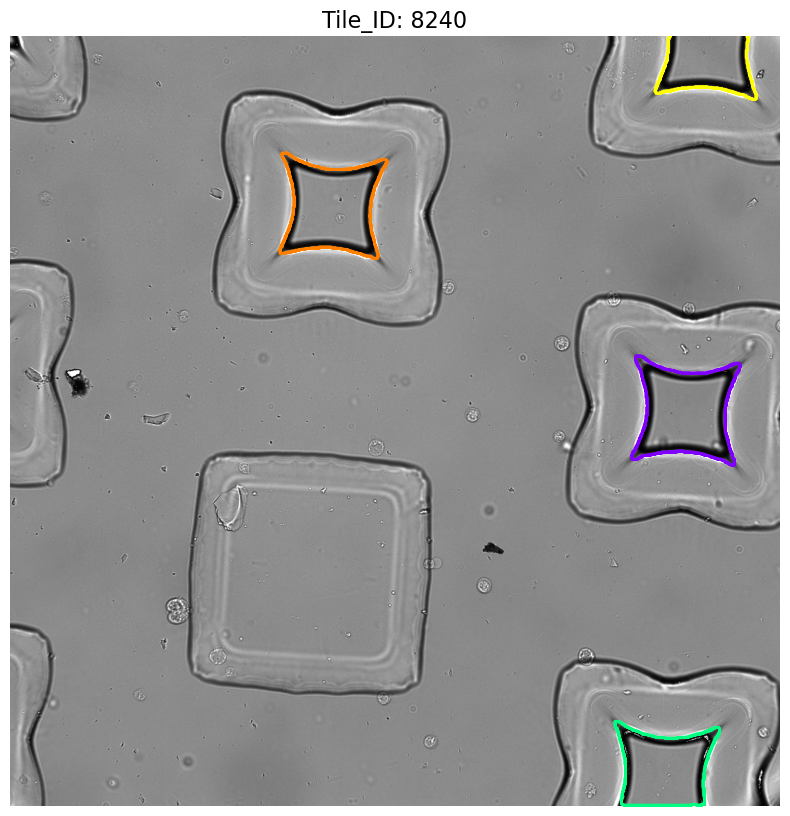

In [12]:
import glob
path_tiles = sorted(glob.glob(os.path.join(path_bf_tiles, '*.tif')))

for path_tile in path_tiles[:1]:
    tile_id = path_tile.split('_')[-2]
    displays.display_cages_with_consistent_colors(path_bf_tiles=path_bf_tiles, tile_id='8240', result_dict=updated_dict, display_ids=False, suffix = '')